In [ ]:
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import tensorflow.keras.metrics
from tensorflow.keras.utils import to_categorical
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
pd.options.display.max_columns
pd.options.display.max_rows

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


60

In [ ]:
!git clone https://github.com/Jmazo25/Monografia.git

Cloning into 'Monografia'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 5 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (5/5), done.


In [ ]:
df = pd.read_csv("/content/Monografia/train.csv")

#Búsqueda de nulos

Previamente ya se detectató una fila con valores nulos por lo cual se procede a eliminar

In [ ]:
df.dropna(axis = 0, how ='any',inplace=True)
df.reset_index(inplace=True)
df.shape

(27480, 5)

#Eiliminación de stop words

In [ ]:
def clean_text(t):
  tl = []
  t = t.lower().split()
  for i in t:
    if i not in stopwords.words('english'):
      tl.append(i)
  return " ".join(tl)

In [ ]:
#Limpiar expresiones Regulares
df['text'] = df['text'].apply((lambda x:re.sub('@[^\s]+','',x)))
df['text'] = df['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
#Remover stopwords
df['text'] = df['text'].apply(lambda x: clean_text(x))

In [ ]:
##Limpiar expresiones Regulares
df['selected_text'] = df['selected_text'].apply((lambda x:re.sub('@[^\s]+','',x)))
df['selected_text'] = df['selected_text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
#Remover StopWords
df['selected_text'] = df['selected_text'].apply(lambda x: clean_text(x))

In [ ]:
df.head(3)

,index,textID,text,selected_text,sentiment
0,0,cb774db0d1,i`d responded going,i`d responded going,neutral
1,1,549e992a42,sooo sad miss san diego,sooo sad,negative
2,2,088c60f138,boss bullying,bullying,negative


Se procede a buscar el tweet con mayor longitud en términos de palabras

In [ ]:
dim_tw = df['text'].str.split().str.len()

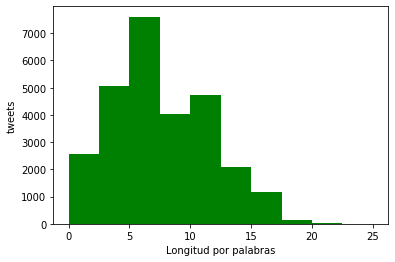

In [ ]:
fig, ax1 = plt.subplots()
plt.hist(dim_tw,color='green')
ax1.set_xlabel('Longitud por palabras'), ax1.set_ylabel("tweets")
plt.show()

In [ ]:
dim_tw.describe()

count    27480.000000
mean         7.416230
std          3.983212
min          0.000000
25%          4.000000
50%          7.000000
75%         10.000000
max         25.000000
Name: text, dtype: float64

#Codificando el texto seleccionado

Función para codificar el texto seleccionado, la cual arroja la posición de la palabra inicial y la final del texto seleccionado en el tweet original

In [ ]:
def outp(t1,t2):
  l, all = [],[]
  t1 = t1.lower().split()
  t2 = t2.lower().split()
  for i in t2:
    for j in t1:
      if i == j:
        l.append(0)
      else:
        l.append(1)
    all.append(np.array(l))
    l = []
  j = np.ones(len(t1))
  for i in all:
    j = j * i
  l2 = []
  for i in j:
    if i == 1:
      l2.append(0)
    else:
      l2.append(1)
  #return np.array(l2,dtype='float32')
  return l2

In [ ]:
df2 = df[['text','selected_text']] 

In [ ]:
y_true = df2.apply(lambda x: outp(x['text'],x['selected_text']),axis=1)

In [ ]:
y_true = list(y_true)

Agregamos padding para que todos los elementos queden de la misma longitud

In [ ]:
def pad(a,ml):
  if len(a) == 0:
    c = np.zeros(ml)
  else:
    b = np.pad(a,ml-len(a))
    c = b[ml-len(a):]
    c = np.array(c,dtype='float32')
  #return list(c)
  return c

In [ ]:
y_true2 = [pad(i,max(dim_tw)) for i in y_true]

In [ ]:
y_true=np.array(y_true2,dtype='float32')

In [ ]:
y_true[0].shape

(25,)

In [ ]:
y_true

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [1., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]], dtype=float32)

#Longitud de cada tweet

Se almacena en una variable la longitud de cada tweet esto para remover el padding al calcular las métricas luego de realizar una predicción al conjunto de test

In [ ]:
def leng2(x):
  return len(x.lower().split())

In [ ]:
def leng(x):
  x = x.lower().split()
  a = len(x)
  return a

In [ ]:
a = 'hola mi nombre es Gufy y soy el mejor perro del mundo'
b = leng2(a)
c = leng(a)
print(b,c)

12 12


In [ ]:
long = df2.apply(lambda x: leng(x['text']),axis=1)
long = np.array(long)

In [ ]:
long

array([ 3,  5,  2, ..., 12,  1,  6])

#Codificación del sentimiento para ser una entrada válida en el modelo


In [ ]:
labels1 = {"sentiment": {"neutral":0,"positive":1,"negative":2}}

In [ ]:
df = df.replace(labels1)
labels = df['sentiment']
#labels
#labels = to_categorical(labels)

In [ ]:
labels

0        0
1        2
2        2
3        2
4        2
        ..
27475    2
27476    2
27477    1
27478    1
27479    0
Name: sentiment, Length: 27480, dtype: int64

In [ ]:
labels.shape

(27480,)

#Tokenización

In [ ]:
text = list(df['text'].values)

In [ ]:
tokenizer = Tokenizer(num_words=12000)
tokenizer.fit_on_texts(text)
sequences = tokenizer.texts_to_sequences(text)

In [ ]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 28612 unique tokens.


In [ ]:
data = pad_sequences(sequences, maxlen=max(dim_tw))

#Split de la data

In [ ]:
X_train,x_test,Y_train,y_test,Labels_train,labels_test,ts_train,ts_test,Long_train, long_test = train_test_split(data,y_true,labels,df['text'],long, test_size=0.15, random_state=42)
x_train,x_val,y_train,y_val,labels_train,labels_val = train_test_split(X_train,Y_train,Labels_train, test_size=0.1, random_state=42)
x_train.shape, y_train.shape,x_val.shape, y_val.shape, x_test.shape, y_test.shape

((21022, 25), (21022, 25), (2336, 25), (2336, 25), (4122, 25), (4122, 25))

In [ ]:
type(y_train)

numpy.ndarray

In [ ]:
labels_train.shape ,labels_test.shape, labels_val.shape, ts_test.shape

((21022,), (4122,), (2336,), (4122,))

#Capa de Embeding

Debido a que pesa más de 400 Mb se pondrá el enlace donde se puede descargar para uso del lector, se debe establecer la variable Path con la ruta donde el archivo esté puesto.
https://nlp.stanford.edu/projects/glove/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/'

In [ ]:
embeddings_index = {}
f = open(os.path.join(path, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
embedding_matrix = np.zeros((tokenizer.num_words + 1, 100))
for i in range(1,tokenizer.num_words):
  word = tokenizer.index_word[i]
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
      embedding_matrix[i] = embedding_vector
  else:
      embedding_matrix[i] = embeddings_index.get('unk')

In [ ]:
from keras.layers import Embedding

embedding_layer = Embedding(tokenizer.num_words + 1,
                            100,
                            weights=[embedding_matrix],
                            input_length=25,
                            trainable=False,
                            mask_zero=True)

#Definición de métricas

In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#Creación del modelo

Importa librerías necesarias

In [ ]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Conv1D, MaxPooling1D, LSTM, RepeatVector, Concatenate
from tensorflow.keras import Model,Input,callbacks
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Bidirectional, TimeDistributed
from keras.layers import Flatten
from keras.layers import Embedding
import tensorflow.keras.backend as K
from tensorflow.keras.metrics import Recall, Precision

In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

Arquitectura del modelo

In [ ]:
sequence_input = Input(shape=(25,), dtype='int32')
sentiment = Input(shape=(1,), dtype='int32')

embedded_sequences = embedding_layer(sequence_input)
xs = Embedding(3,20)(sentiment)
xs = Flatten()(xs)
xs = RepeatVector(25)(xs)

x = Concatenate(axis=-1)([xs,embedded_sequences])

x = Bidirectional(LSTM(50,return_sequences=True))(x)
x = Bidirectional(LSTM(50,return_sequences=True))(x)
x = TimeDistributed(Dense(128, activation='relu'))(x)
preds = TimeDistributed(Dense(1, activation='sigmoid'))(x)

model = Model(inputs=[sequence_input,sentiment], outputs = preds)

optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)

model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy',Recall(), f1_m, Precision()])
model.summary()


model.fit([x_train,labels_train], y_train.reshape(y_train.shape[0],y_train.shape[1],1),validation_data= ([x_val,labels_val], y_val.reshape(y_val.shape[0],y_val.shape[1],1)),
          epochs=15, batch_size=32, verbose=1)

loss, accuracy,recall, F1, precision = model.evaluate([x_test,labels_test],y_test.reshape(y_test.shape[0],y_test.shape[1],1) , verbose=0,batch_size=128)
print('Accuracy: %f' % (accuracy*100))
print('recall: %f' % (recall*100))
print('F1: %f' % (((2*recall*precision) / (recall + precision))*100))
print('Precision: %f' % (precision*100))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 20)        60          input_2[0][0]                    
__________________________________________________________________________________________________
flatten (Flatten)               (None, 20)           0           embedding_1[0][0]                
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 25)]         0                                            
______________________________________________________________________________________________

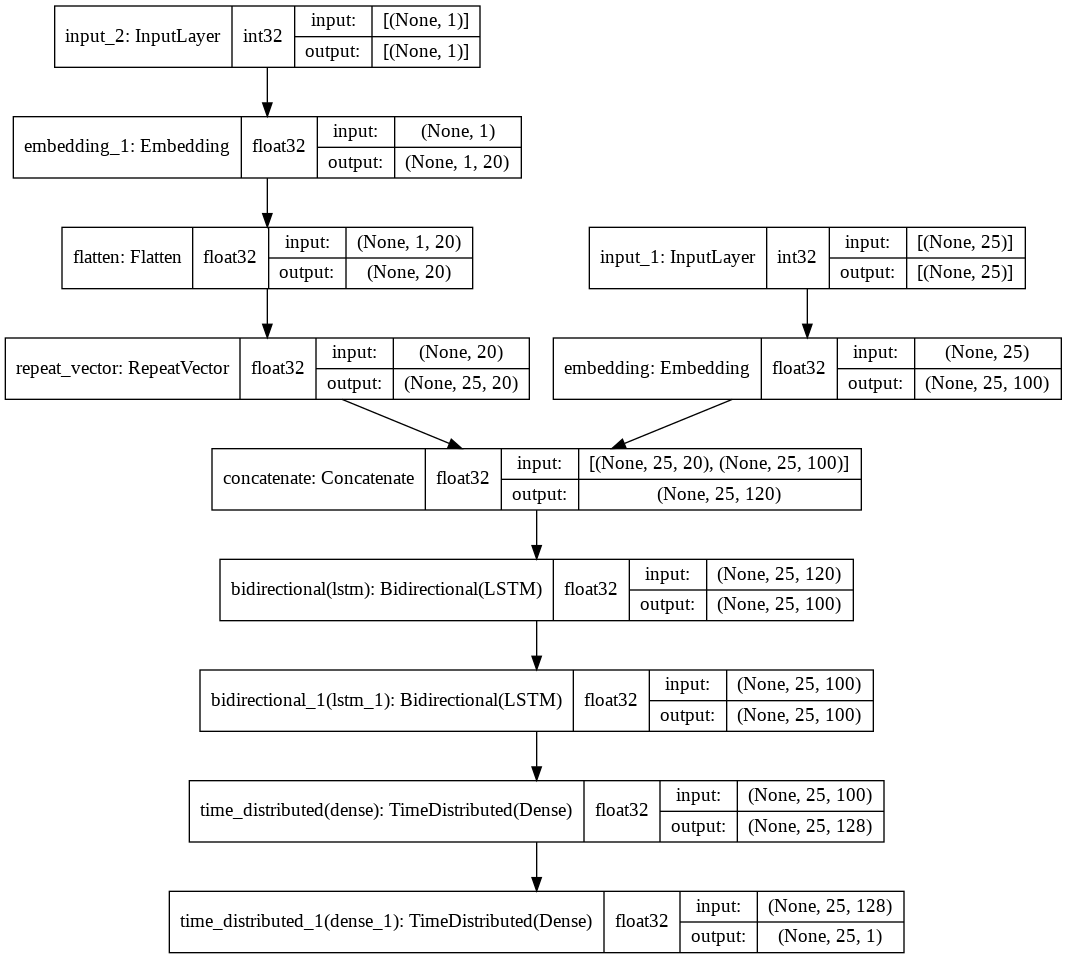

In [ ]:
tensorflow.keras.utils.plot_model(model, "BOW.png",show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96,
    layer_range=None)

In [ ]:
print('Shape of data tensor:', data.shape)
#print('Shape of label label:', y_true2.shape)

Shape of data tensor: (27480, 25)


Predicción del modelo

In [ ]:
pred = model.predict([x_test,labels_test])

In [ ]:
pred.shape

(4122, 25, 1)

Función para decodificar la variable de predicción:

In [ ]:
def dec(x):
  r1=[]
  for i in range(x.shape[0]):
    l1 = []
    for j in range(x[i].shape[0]):
      if x[i][j][0] > 0.5:
        l1.append(1)
      else:
        l1.append(0)
    r = np.array(l1,dtype='float32')
    r1.append(r)
  return(np.array(r1,dtype='float32'))   


In [ ]:
y_pred = dec(pred)

In [ ]:
y_test[0].shape

(25,)

#MÉTRICAS

In [ ]:
print('recall:{}'.format(recall_m(y_test,y_pred)))
print('precision:{}'.format(precision_m(y_test,y_pred)))
print('F1:{}'.format(f1_m(y_test,y_pred)))

recall:0.04632323607802391
precision:0.7740705609321594
F1:0.08741521090269089


##Accuracy

In [ ]:
p = 0
for n in range(y_test.shape[0]):
  for l in range(y_test[n].shape[0]):
    if y_test[n][l] == y_pred[n][l]:
      p = p + 1
print(p / (y_test.shape[0]*y_test.shape[1]))

0.8354779233381854


##Precision

In [ ]:
fp = 0
tp = 0
for n in range(y_test.shape[0]):
  for l in range(y_test[n].shape[0]):
    #if y_test[n][l] == 1:
      #tp = tp + 1
    if y_test[n][l] == y_pred[n][l] and y_pred[n][l] == 1:
      tp = tp + 1
    if y_test[n][l] != y_pred[n][l] and y_pred[n][l] == 1:
      fp = fp + 1 
print(tp/(tp+fp))

0.7740705433746425


##Recall

In [ ]:
fn = 0
tp = 0
for n in range(y_test.shape[0]):
  for l in range(y_test[n].shape[0]):
    if y_test[n][l] == y_pred[n][l] and y_pred[n][l] == 1:
      tp = tp + 1
    if y_test[n][l] != y_pred[n][l] and y_pred[n][l] == 0:
      fn = fn + 1 


print(tp/(tp+fn))

0.04632323578070626


#Removiendo padding

In [ ]:
def withoutpadding(x,y):
  f = []
  for k,i in enumerate(x):
    a = i[:y[k]]
    f.append(a)
  return np.array(f)

In [ ]:
y_test_t = withoutpadding(y_test,long_test)
y_pred_p = withoutpadding(y_pred,long_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


##Jaccard

In [ ]:
text_true = list(ts_test)

In [ ]:
text_true

Función dec jaccard

In [ ]:
def decjac(a,b):
  op=[]
  for i,j in enumerate(a):
    if j == 1:
      op.append(b.split()[i])
  return " ".join(op)

In [ ]:
j_test=[]
for ki in range(len(text_true)):
  j_test.append(decjac(y_test_t[ki],text_true[ki]))

In [ ]:
j_pred=[]
for kp in range(len(text_true)):
  j_pred.append(decjac(y_pred_p[kp],text_true[kp]))

In [ ]:
j_test


In [ ]:
def jaccard(str1, str2):
    if len(str1) == 0 and len(str2) == 0:
      return 0.0
    else:
      a = set(str1.lower().split()) 
      b = set(str2.lower().split())
      c = a.intersection(b)
      return float(len(c)) / (len(a) + len(b) - len(c))

In [ ]:
rest2 = [jaccard(j_test[i],j_pred[i]) for i in range(len(j_test))]

In [ ]:
print("el promedio de jaccard es: {}".format(sum(rest2)/len(rest2)))

el promedio de jaccard es: 0.013568732945589074
